In [1]:
using Distributions
using Random
using Plots

## Problem
**Input:**  A set $\mathcal{V}$ of $N\times I$ vectors of dimension $T$ and a partition of $\mathcal{V}$ into $I$ classes of $N$ vectors, denoted by $\mathcal{S}_i=\{\mathbf{v}_1^i,\ldots,\mathbf{v}_N^i\}$.

**Solution:** A partition of $\mathcal{V}$ into $N$ clusters $\mathcal{V}_k$ of size $I$, such that each cluster contains exactly one vector of each class $\mathcal{S}_i$.  

## Random Data Generation
Given the problem dimensions $N$, $T$, $I$, and a number $\sigma>0$, synthetic data for testing is generated as a 3-dimensional ($N\times T\times I$) array of numbers <code>S</code> in two steps as follows:

1. $N$ vectors $\mu_n$ are selected uniformly at random from the region $[-1,1]^T\subset\mathbb{R}^T$.

2. For each $n=1,\ldots,N$; $I$ vectors are sampled from a $\mathcal{N}(\mu_n,\sigma^2 I)$ distribution and stored on the <code>S[n,:,:]</code> slide of the array. 

In [2]:
function generate_random_data(
            N::Int64,           # Number of clusters to be found
            T::Int64,           # Dimension of elements to cluster
            I::Int64,           # Number of initial classes
            σ=.2::Float64,      # "Standard deviation" of sampling
            seed=rand(UInt32)::UInt32
        )
    
    # Random number generator with given seed
    rng = MersenneTwister(seed)
    
    # Step 1: Centers 
    centers_dist = Product(Uniform.(-ones(T), ones(T)))
    μs = rand(rng, centers_dist, N)
    
    # Step 2: Data
    Σ = σ^2*ones(Float64, T)
    S = Array{Float64, 3}(undef, N, T, I) # Julia's sintaxis: 3-dimensional array of floats uninitialized of size N x T x I 
    for n = 1:N
        data_dist = MvNormal(μs[:,n], Σ)
        S[n,:,:] = rand!(rng, data_dist, Array{Float64,2}(undef, T, I))
    end
    
    return S
end

generate_random_data (generic function with 3 methods)

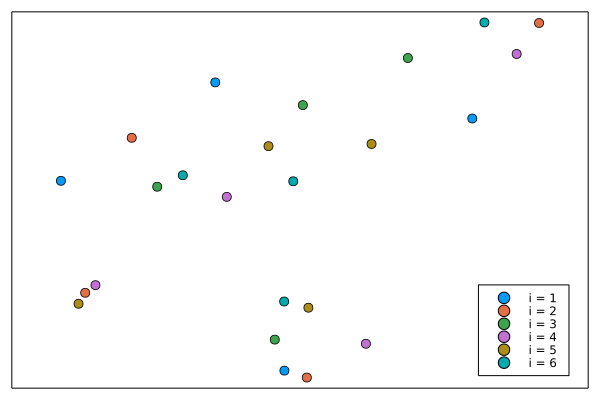

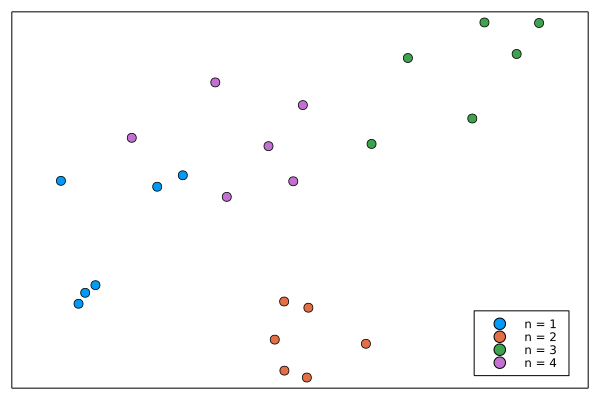

In [3]:
# Small illustrative example of random data
N = 4
T = 2
I = 6
σ = .5
seed = 100
S = generate_random_data(N, T, I, σ, seed)

# Figure with coloring according to class
plt_i = scatter(grid=false,framestyle=:box, ticks=false)
for i = 1:I
    scatter!(S[:,1,i], S[:,2,i], aspect_ratio = 1, label="i = $i", legend=:bottomright, m=5)
end
display(plt_i)

# Figure with coloring according to the generating cluster. 
# Note that each cluster contains exactly one point of each color of the previous figure
plt_n = scatter(grid=false,framestyle=:box, ticks=false)
for n = 1:N
    scatter!(S[n,1,:], S[n,2,:], aspect_ratio = 1, label="n = $n", legend=:bottomright, m=5)
end
display(plt_n)


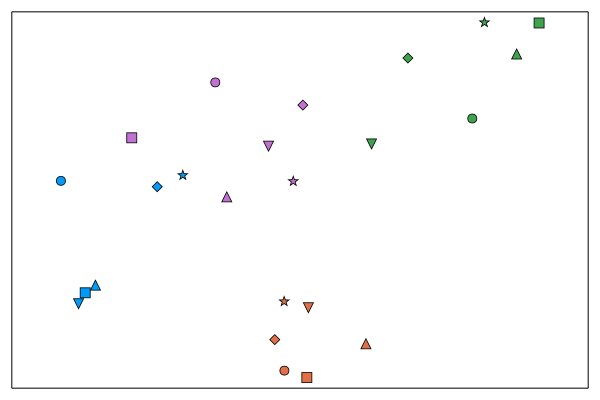

In [4]:
plt = scatter(grid=false,framestyle=:box, ticks=false)
shapes = [:circle, :rect, :diamond, :utriangle, :dtriangle, :star5]
for i = 1:I
    for n = 1:N
        scatter!([S[n,1,i]], [S[n,2,i]], aspect_ratio = 1, label="n = $n", legend=:none, color=n, markershape=shapes[i], m=5)
    end
end
display(plt)

## Solution Representation
Solutions to the problem are represented by a cluster-membership matrix $\mathbf{Y}=[y_n^i]$ of size $I\times N$ were $y_n^i\in\{1,\ldots,N\}$.

We interpret $y_n^i=k$ to mean that the vector $\mathbf{v}_n^i$ is on the cluster $\mathcal{V}_k$. Explicitly, the decoding function for a given matrix $\textbf{Y}$ constructs $N$ the clusters by:

$$\mathcal{V}_k = \{\mathbf{v}_n^i\in\mathcal{V}~|~y_n^i=k,~i\in \{1,\ldots,I\}\}$$

**Note:** For a matrix $\mathbf{Y}$ to be a valid solution to the problem, each one of its rows must be a permutation of $(1,\ldots,N)$. 

In [5]:
function generate_random_solution!(
            Y::Array{Int32,2},  # Array to overwrite the new solution over  
            seed=rand(UInt32)::UInt32
        )   
    I, N = size(Y)
    
    # Random number generator with given seed
    rng = MersenneTwister(seed)
    
    # Filling
    for i = 1:I
        Y[i,:] = randperm(rng, N)
    end
    
    return Y
end

function generate_random_solution(
            N::Int64,           # Number of clusters to be found
            I::Int64,           # Number of initial classes
            seed=rand(UInt32)::UInt32    
        )
    
    # Memory allocation
    Y = Array{Int32, 2}(undef, I, N)
    
    generate_random_solution!(Y, seed)
    
    return Y
end

generate_random_solution (generic function with 2 methods)

In [6]:
# 2-dimensional plotter for small illustrative examples
function plot_T2_clustering(S, Y, centers=nothing)
    plt_Y = scatter(aspect_ratio = 1, grid=false,framestyle=:box, ticks=false)
    for k = 1:N
        cluster = Array{Float64, 2}(undef, I, T)
        for i = 1:I
            for n = 1:N
                Y[i,n]==k ? cluster[i,:]=S[n,:,i] : nothing
            end
        end    
        scatter!(cluster[:,1], cluster[:,2], label="V_$k", legend = :bottomright)
        if !isnothing(centers)
            scatter!([centers[k,1]], [centers[k,2]], primary = false, markershape = :star, legend = :bottomright, m=5)
        end
    end
    display(plt_Y)
end


plot_T2_clustering (generic function with 2 methods)

6×4 Matrix{Int32}:
 1  2  3  4
 1  2  3  4
 1  2  3  4
 1  2  3  4
 1  2  3  4
 1  2  3  4

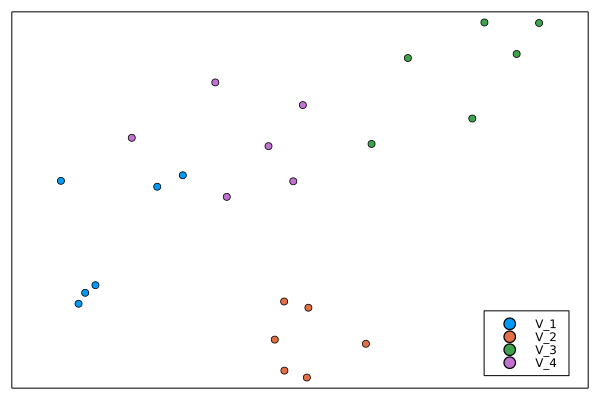

In [7]:
Y = repeat(transpose(Int32.(1:N)), I)

display(Y)
plot_T2_clustering(S, Y)

6×4 Matrix{Int32}:
 1  3  2  4
 3  1  2  4
 4  1  3  2
 4  1  3  2
 1  3  2  4
 2  3  4  1

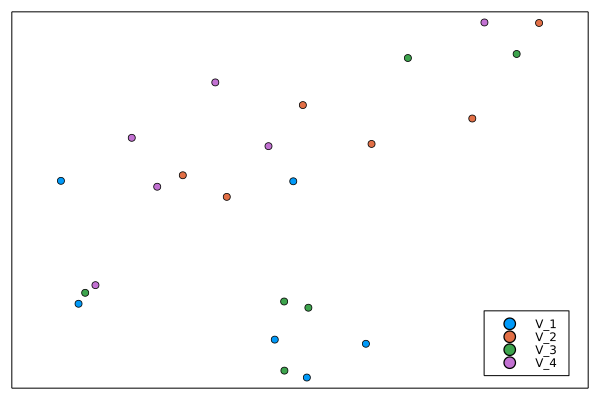

In [8]:
Y = generate_random_solution(N, I)

display(Y)
plot_T2_clustering(S, Y)

## Objective Function
The objective function considered here is the same as in the k-means algorithm; the sum of each element's distances to the mean over its cluster elements.

$$OF=\displaystyle\sum_{n=1}^N\sum_{\mathbf{v}\in\mathcal{V}_n}d(\mathbf{v},\mu_n),~~\text{ were }\mu_n=\frac1{I}\sum_{\mathbf{v}\in\mathcal{V}_n}\mathbf{v}$$

In [9]:
function generate_centers_means!(
            S::Array{Float64,3}, 
            Y::Array{Int32,2},
            centers::Array{Float64, 2}
        )
    N, T, I = size(S)
    
    for k = 1:N
        for i = 1:I
            for n = 1:N
                Y[i,n]==k ? centers[k,:]+=S[n,:,i]/I : nothing
            end
        end
    end
    
    return centers
end

function generate_centers_means(
            S::Array{Float64,3}, 
            Y::Array{Int32,2}
        )
    N, T, I = size(S)
    
    centers = zeros(Float64, N, T)
    generate_centers_means!(S, Y, centers)
    
    return centers
end

generate_centers_means (generic function with 1 method)

In [10]:
# HERE MUCH MORE CARE IS NEEDED!!!

function objective_function(
            S::Array{Float64,3}, 
            Y::Array{Int32,2},
            centers=nothing::Array{Float64,2}
        )
    
    if isnothing(centers)
        centers = generate_centers_means(S, Y)
    end
    
    sum = 0
    N, T, I = size(S)
    for i = 1:I
        for n = 1:N 
            sum += dist_euc(S[n,:,i], centers[Y[i,n],:])
        end
    end
    return sum
end

# just for testing, fix to work with the distances package (or concretize types)
function dist_euc(u::Array{Float64,1} ,v::Array{Float64,1})
    T = length(u) 
    sqsum = 0
    for t = 1:T
        sqsum += (u[t] - v[t])^2
    end
    return sqrt(sqsum)    
end

dist_euc (generic function with 1 method)

6×4 Matrix{Int32}:
 2  4  1  3
 4  2  3  1
 4  3  1  2
 4  2  1  3
 3  2  4  1
 1  2  3  4

14.501117083095243

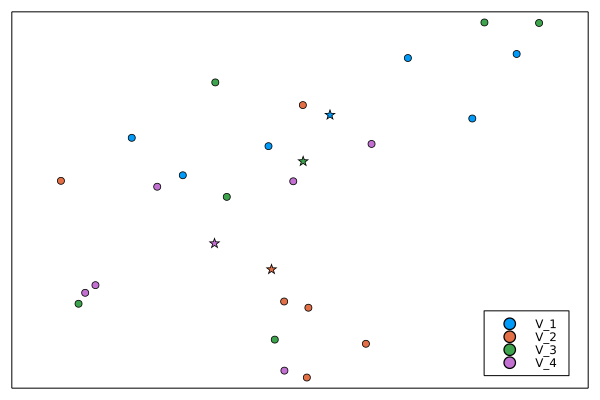

In [11]:
# Y = repeat(transpose(Int32.(1:N)), I)
Y = generate_random_solution(N,I)

centers = generate_centers_means(S, Y)

display(Y)
display(objective_function(S, Y, centers))
plot_T2_clustering(S, Y, centers)

## New Solution Generation

Given a solution $\mathbf{Y}$, two mechanisms are considered to generate a new one.

1. **Single swap neighbour:** A unique swap $y_n^i\leftrightarrow y_m^i$, is performed over two entries of the same row $i$ of the matrix $\mathbf{Y}$.

2. **Multiple row perturbation:** Assuming current clusters centers $\mu_k$ are known, a single row $i$ of the matrix $\mathbf{Y}$ can be permuted by selecting (in random order) each of the corresponding elements $\mathbf{v}_n^i$ and assigning it to the closest center with no element assigned yet. We say that a  $\beta$-perturbation makes such reordering to $\lfloor\beta I\rfloor$ of the rows of $\mathbf{Y}$.

**Note:** A possible randomized greedy strategy makes successive 1-permutations keeping the new solution if the total cost decrease.

In [12]:
function inm_neighbour!(
            Y::Array{Int32,2},  # Solution to be modified
            i::Int,             # Row of swap
            n::Int,             # 1st element swaped
            m::Int              # 2nd element swaped
        )
    k = Y[i,n]
    Y[i,n] = Y[i,m]
    Y[i,m] = k
end

function random_neighbour!(
            Y::Array{Int32,2},          # Solution to be modified
            seed=rand(UInt32)::UInt32, 
            method=:singleswap          # This option is here to test later the effect of doubleswap or other strategies
        )
    I, N = size(Y)
    rng = MersenneTwister(seed)
    
    if method==:singleswap
        n, m = randperm(rng, N)[1:2]
        i = rand(rng, 1:I)
        
        inm_neighbour!(Y, i, n, m)
    end
end

function random_neighbour(
            Y::Array{Int32,2}, 
            seed=rand(UInt32)::UInt32, 
            method=:singleswap
        )
    Ynew = copy(Y)
    random_neighbour!(Ynew, seed, method)
    
    return Ynew
end

random_neighbour (generic function with 3 methods)

In [13]:
function rand_rows_2_nearest_center!(
            S::Array{Float64,3}, 
            Y::Array{Int32,2},
            centers::Array{Float64,2},
            β::Float64,                    # Proportion of the rows to modify
            seed=rand(UInt32)::UInt32
        )
    N, T, I = size(S)
    rng = MersenneTwister(seed)
    
    rows2move = floor(Int64, β*I)
    Iperm = randperm(rng, I)[1:rows2move]
    for i in Iperm
        Nperm = randperm(rng, N)
        available = ones(Bool, N)
        for n in Nperm
            dist2cent = Inf * ones(Float64, N)
            for k = 1:N
                if available[k]
                    dist2cent[k] = dist_euc(S[n,:,i], centers[k,:])
                end
            end
            c = argmin(dist2cent)
            available[c] = 0
            Y[i,n] = c
        end
    end
    return Y
end

function rand_rows_2_nearest_center(
            S::Array{Float64,3}, 
            Y::Array{Int32,2},
            centers::Array{Float64,2},
            β::Float64,                    # Proportion of the rows to modify
            seed=rand(UInt32)::UInt32
        )
    Ynew = copy(Y)
    rand_rows_2_nearest_center!(S, Ynew, centers, β, seed)
    return Ynew
end

rand_rows_2_nearest_center (generic function with 2 methods)

# Single-Solution Metaheuristics

### Random Local Search

According to Talbi, local search is likely the oldest and simplest metaheuristic. The idea is to start from a randomly generated solution and then move through the search space generating each possible neighbor to the current solution and selecting an improved one iteratively until some stopping criteria are reached.

Two main modifications are considered for the following implementation.

**Random neighbor generation:** due to the particular characteristics of the problem, it is not practical to generate at every iteration each one of the  $O(N^2I)$ valid neighbors to the current solution. Instead, only a fixed number of neighbors are generated at each step selected uniformly at random from the full neighborhood, this <code>nbhdsize</code> parameter is the main tuning device of the implementation. 

**Objective function proxy:** to consider $OF$ solely as a function of the assignment matrix $Y$, new cluster centers should be calculated. The burden of performing this operation each time $OF$ is evaluated for a neighbor is alleviated by considering a proxy objective function. 

Given that the single swap mutation is used to form neighbors, it could be expected that centers' change is slight at each step. The idea is to retain in memory only the current set of cluster centers and evaluate $OF$ using them for all the tested neighbors, actualizing the centers only when a new, improved solution is selected. 

In [14]:
 ## Proxy OF test K neighbors from same Y
N = 4
T = 2  # Same as below for T growth?? test
I = 6  # Observe that the difference significantly reduces as I grows
σ = .63
S = generate_random_data(N, T, I, σ, 100)

K = 20 # Population size
seed = 12
rng = MersenneTwister(seed)

Y = generate_random_solution(N, I, seed)
centers = generate_centers_means(S, Y)

Ynbhd = Array{Array{Int32, 2}, 1}(undef, K)

costs_proxy = zeros(K)
costs_real = zeros(K)
for k = 1:K
    newseed = rand(rng, UInt32)
    Ynbhd[k] = random_neighbour(Y, newseed, :singleswap)
    costs_proxy[k] = objective_function(S, Ynbhd[k], centers)
    costs_real[k] = objective_function(S, Ynbhd[k], generate_centers_means(S, Ynbhd[k]))
    # display(Ypop[k])
end

display(sum(abs.(costs_proxy - costs_real))/K)
#plot(costs_real, label = "real")
#plot!(costs_proxy, label = "proxy")

0.16757548610748527

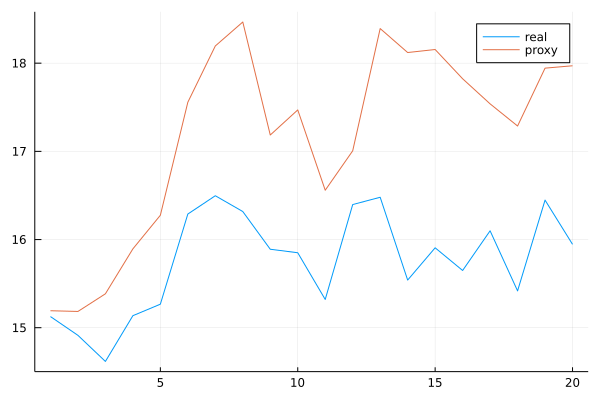

In [15]:
 ## Proxy OF test ## Proxy OF test K successive neighbors starting at Y
N = 4
T = 2
I = 6 
σ = .63
S = generate_random_data(N, T, I, σ, 100)

K = 20 # Population size
seed = 123
rng = MersenneTwister(seed)

Y = generate_random_solution(N, I, seed)
centers = generate_centers_means(S, Y)

Ynbhd = Array{Array{Int32, 2}, 1}(undef, K)

costs_proxy = zeros(K)
costs_real = zeros(K)
for k = 1:K
    newseed = rand(rng, UInt32)
    if k != 1
        Ynbhd[k] = random_neighbour(Ynbhd[k-1], newseed, :singleswap)
    else
        Ynbhd[k] = random_neighbour(Y, newseed, :singleswap)
    end
    costs_proxy[k] = objective_function(S, Ynbhd[k], centers)
    costs_real[k] = objective_function(S, Ynbhd[k], generate_centers_means(S, Ynbhd[k]))
    # display(Ypop[k])
end

plot(costs_real, label = "real")
plot!(costs_proxy, label = "proxy")

1.07640193216457

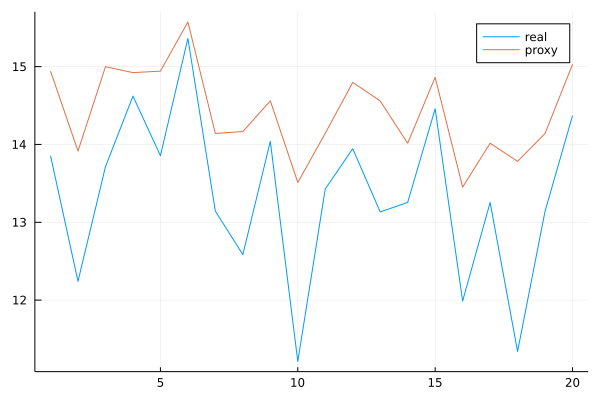

In [16]:
## Proxy OF test K perturbations from same Y
N = 4
T = 2
I = 6 # Observe that (for fix β) the difference increases as I grows
σ = .63
S = generate_random_data(N, T, I, σ, 100)
β = .5


K = 20 # Population size
seed = 123
rng = MersenneTwister(seed)

Y = generate_random_solution(N, I, seed)
centers = generate_centers_means(S, Y)

Ynbhd = Array{Array{Int32, 2}, 1}(undef, K)

costs_proxy = zeros(K)
costs_real = zeros(K)
for k = 1:K
    newseed = rand(rng, UInt32)
    Ynbhd[k] = rand_rows_2_nearest_center(S, Y, centers, β, newseed)
    costs_proxy[k] = objective_function(S, Ynbhd[k], centers)
    costs_real[k] = objective_function(S, Ynbhd[k], generate_centers_means(S, Ynbhd[k]))
    # display(Ypop[k])
end

display(sum(abs.(costs_proxy - costs_real))/K)
plot(costs_real, label = "real")
plot!(costs_proxy, label = "proxy")

In [17]:
function MH1_rand_local_search(
            S::Array{Float64,3}, 
            Y::Array{Int32,2}, 
            maxiter::Int, 
            tolerance::Real, 
            nbhdsize::Int, 
            seed=rand(UInt32)::UInt32
        )
    N, T, I = size(S)

    centers = generate_centers_means(S, Y)
    rng = MersenneTwister(seed)
    
    iter = 1
    cost = [objective_function(S, Y, centers)]
    costnbhd = copy(cost)

    while (cost[end] > tolerance) && (iter < maxiter)
        Ybest = copy(Y)
        costbest = cost[end]
        
        for nbr = 1:nbhdsize
            newseed = rand(rng, UInt32)
            Ynew = random_neighbour(Y, newseed, :singleswap)
            costnew = objective_function(S, Ynew, centers)
            costnbhd = cat(dims=1, costnbhd, costnew)
            if costnew < costbest
                Ybest = copy(Ynew)
                costbest = costnew
                cost = cat(dims=1, cost, costbest)
            else
                cost = cat(dims=1, cost, cost[end])
            end
        end
        
        Y = copy(Ybest)
        
        iter = iter + 1
        centers = generate_centers_means(S, Y)
    end
    
    return Y, cost, costnbhd, centers
end

MH1_rand_local_search (generic function with 2 methods)

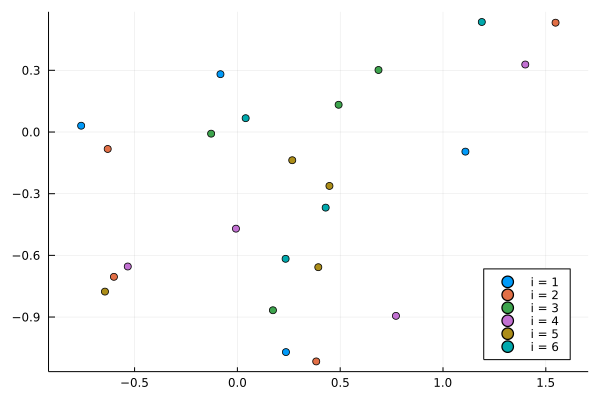

6×4 Matrix{Int32}:
 1  2  3  4
 1  2  3  4
 1  2  3  4
 1  2  3  4
 1  2  3  4
 1  2  3  4

9.72918673926594

4×2 Matrix{Float64}:
 -0.437514  -0.34079
  0.365279  -0.870218
  1.06322    0.223168
  0.07807   -0.1073

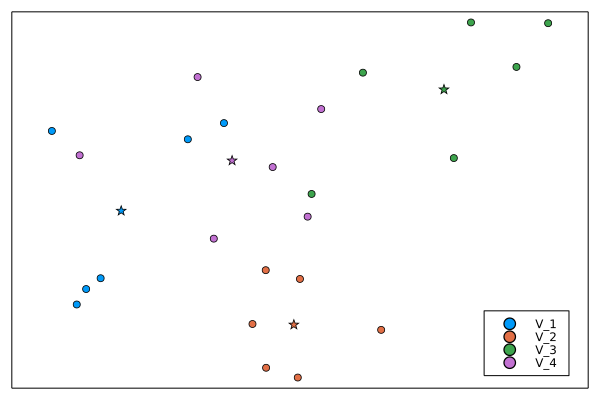

In [18]:
N = 4
T = 2
I = 6
σ = .63
S = generate_random_data(N, T, I, σ, 100)


plt_i = scatter()
for i = 1:I
    scatter!(S[:,1,i], S[:,2,i], aspect_ratio = 1, label="i = $i", legend=:bottomright)
end
display(plt_i)


# Small illustrative example of solution

#Y = generate_random_solution(N,I)
Y = repeat(transpose(Int32.(1:N)), I)
centers = generate_centers_means(S, Y)

display(Y)
display(objective_function(S, Y, centers))
display(centers)
plot_T2_clustering(S, Y, centers)

6×4 Matrix{Int32}:
 2  1  3  4
 2  1  3  4
 2  1  3  4
 2  1  3  4
 2  1  3  4
 4  1  3  2

9.596764978962904

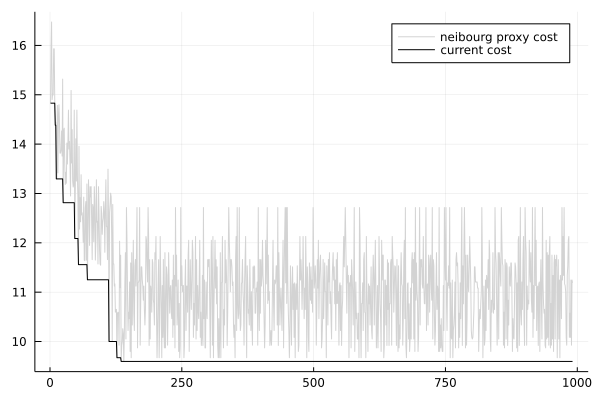

In [19]:
maxiter = 100
tolerance = 1
nbhdsize = 10
seed = 1234

Y = generate_random_solution(N, I, seed)
Yrls, cost, costnbhd = MH1_rand_local_search(S, Y, maxiter, tolerance, nbhdsize, seed)

display(Yrls)
display(cost[end])
pltcost = plot()
plot!(costnbhd, color=:lightgrey, label="neibourg proxy cost")
plot!(cost, color=:black, label="current cost")
display(pltcost)


### Simulated Annealing

In [20]:
function MH2_simulated_annealing(
            S::Array{Float64,3}, 
            Y::Array{Int32,2}, 
            maxiter::Int, 
            tolerance::Real, 
            tempsize::Int,
            tempstart::Real,
            α::Real,
            seed=rand(UInt32)::UInt32
        )
    N, T, I = size(S)
    
    centers = generate_centers_means(S, Y)
    temp = [tempstart]
    rng = MersenneTwister(seed)
    
    iter = 1
    cost = [objective_function(S, Y, centers)]
    costbest = copy(cost)
    costreal = copy(cost)
    Ybest = copy(Y)
    
    while (cost[end] > tolerance) && (iter < maxiter)
        
        for rep = 1:tempsize
            newseed = rand(rng, UInt32)
            Ynew = random_neighbour(Y, newseed, :singleswap)
            costnew = objective_function(S, Ynew, centers) # to use same centers as here or new ones??
            ΔE = costnew - cost[end]
            if ΔE < 0
                Y = copy(Ynew)
                cost = cat(dims=1, cost, costnew)
            else
                aceptprob = exp(-ΔE/temp[end])
                if rand(rng) < aceptprob
                    Y = copy(Ynew)
                    cost = cat(dims=1, cost, costnew)
                else
                    cost = cat(dims=1, cost, cost[end])
                end
            end
            if cost[end]<costbest[end]
                costbest = cat(dims=1, costbest, cost[end])
            else
                costbest = cat(dims=1, costbest, costbest[end])
            end
            costreal = cat(dims=1, costreal, costreal[end])
        end
        
        
        temp = cat(dims=1, temp, α*temp[end])        
        iter = iter + 1
        centers = generate_centers_means(S, Y)
        costreal[end] = objective_function(S, Y, centers)
    end
    
    return Y, cost, costbest, costreal, temp, centers
end

MH2_simulated_annealing (generic function with 2 methods)

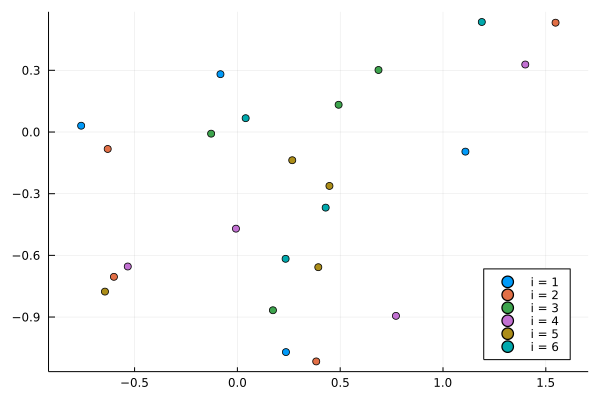

6×4 Matrix{Int32}:
 1  2  3  4
 1  2  3  4
 1  2  3  4
 1  2  3  4
 1  2  3  4
 1  2  3  4

9.72918673926594

4×2 Matrix{Float64}:
 -0.437514  -0.34079
  0.365279  -0.870218
  1.06322    0.223168
  0.07807   -0.1073

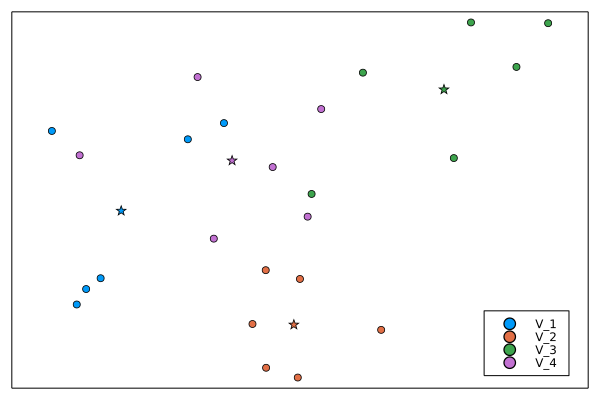

In [21]:
N = 4
T = 2
I = 6
σ = .63
S = generate_random_data(N, T, I, σ, 100)


plt_i = scatter()
for i = 1:I
    scatter!(S[:,1,i], S[:,2,i], aspect_ratio = 1, label="i = $i", legend=:bottomright)
end
display(plt_i)


# Small illustrative example of solution

#Y = generate_random_solution(N,I)
Y = repeat(transpose(Int32.(1:N)), I)
centers = generate_centers_means(S, Y)

display(Y)
display(objective_function(S, Y, centers))
display(centers)
plot_T2_clustering(S, Y, centers)

6×4 Matrix{Int32}:
 4  3  2  1
 4  3  2  1
 4  3  2  1
 4  3  2  1
 4  3  2  1
 1  3  2  4

9.629903638632332

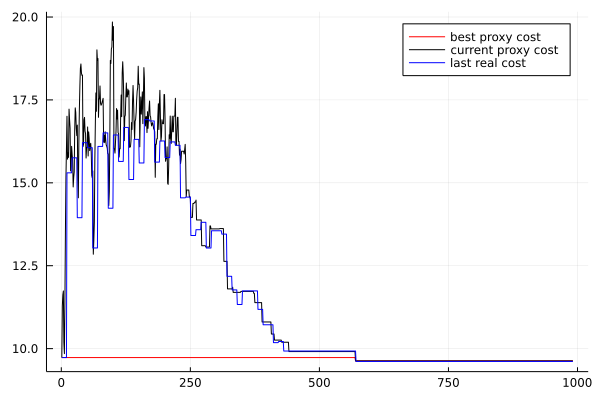

In [22]:
maxiter = 100
tolerance = 1
tempsize = 10
tempstart = 100.
α = .8
seed = 1234


Ysa, cost, costbest, costreal, temp = MH2_simulated_annealing(S, Y, maxiter, tolerance, tempsize, tempstart, α, seed)

display(Ysa)
display(cost[end])
pltcost = plot()
plot!(costbest, color=:red, label="best proxy cost")
plot!(cost, color=:black, label="current proxy cost")
plot!(costreal, color=:blue, label="last real cost")
display(pltcost)
# plot(temp, color=:black, label="temperature", ylims=(-.01tempstart, tempstart/2))

### Iterated Local Search

In [23]:
function MH3_iterated_local_search(
            S::Array{Float64,3}, 
            Y::Array{Int32,2},
            maxitermain::Int,
            maxiter::Int, 
            tolerance::Real, 
            nbhdsize::Int,
            β::Real,
            seed=rand(UInt32)::UInt32
        )
    
    N, T, I = size(S)
    Y, cost, costnbhd = MH1_rand_local_search(S, Y, maxiter, tolerance, nbhdsize, seed)
    costtemp = copy(cost)
    centers = generate_centers_means(S, Y)
    rng = MersenneTwister(seed)
    perturbindex = Array{Int64, 1}(undef,0)
    
    iter = 1

    while (cost[end] > tolerance) && (iter < maxitermain)
        newseed = rand(rng, UInt32)
        perturbindex = cat(dims=1, perturbindex, length(cost))
        
        # Perturb the obtained local optima
        Ynew = rand_rows_2_nearest_center(S, Y, centers, β, newseed)
        # dinamic β better?
        
        # Apply local search on the perturbed solution
        Ynew, cost_, costnbhd_, centers_ = MH1_rand_local_search(S, Ynew, maxiter, tolerance, nbhdsize, newseed)
        
        # Accepting criteria
        if cost_[end] < cost[end]
            Y = copy(Ynew)
            centers = copy(centers_)
        end
        
        cost = cat(dims=1, cost, min.(cost[end],cost_))
        costtemp = cat(dims=1, costtemp, cost_)
        costnbhd = cat(dims=1, costnbhd, costnbhd_)
        iter = iter + 1
    end
    
    return Y, cost, costtemp, costnbhd, perturbindex, centers
end



MH3_iterated_local_search (generic function with 2 methods)

6×4 Matrix{Int32}:
 1  2  4  3
 1  2  4  3
 1  2  4  3
 1  2  4  3
 1  2  4  3
 3  2  4  1

9.596764978962904

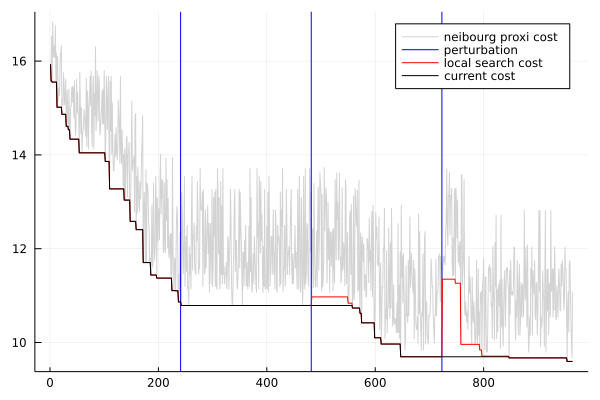

In [24]:
maxitermain = 4
maxiter = 25
tolerance = 1
nbhdsize = 10 
β = .5
seed = 1234567

Y = generate_random_solution(N, I, seed)
Yils, cost, costtemp, costnbhd, perturbindex = MH3_iterated_local_search(S, Y, maxitermain, maxiter, tolerance, nbhdsize, β, seed)

display(Yils)
display(cost[end])
pltcost = plot()
plot!(costnbhd, color=:lightgrey, label="neibourg proxi cost")
vline!(perturbindex, color=:blue, label="perturbation")
plot!(costtemp, color=:red, label="local search cost")
plot!(cost, color=:black, label="current cost")
display(pltcost)


100×10 Matrix{Int32}:
 6   8  1   2   5  7  10   9   3   4
 4   8  5   6   7  3   9   2  10   1
 1  10  9   2   6  4   5   7   8   3
 6   8  4   2   9  7   5   1   3  10
 4   8  6   5  10  3   7   9   2   1
 6   2  9  10   1  3   4   7   5   8
 1   8  6   2   4  9  10   7   3   5
 2   1  9   3   8  6   5   7   4  10
 6   8  9   2   3  1   4   7  10   5
 7   8  6   1   9  5   2   4   3  10
 2   8  1   6   9  4  10   7   3   5
 6   8  9   1   2  4   5   7   3  10
 6   8  1   4   2  9   5   7   3  10
 ⋮                 ⋮              
 6   1  8   7   2  4   5  10   3   9
 6   1  8   2   7  9   3   4   5  10
 5   8  1   2   9  7   6   4   3  10
 1   9  4   7   8  6   5  10   3   2
 6   8  1   4   9  3  10   7   5   2
 8   1  6   2   4  9   5   7   3  10
 6   1  4   5   8  9  10   7   3   2
 6   8  9   2  10  4   5   7   3   1
 2   8  3   1   6  9   5   4  10   7
 1   8  6   3   5  4  10   7   9   2
 6   8  2   4   9  1   5   7   3  10
 6   8  1   2   4  9   5   7   3  10

156283.862512202

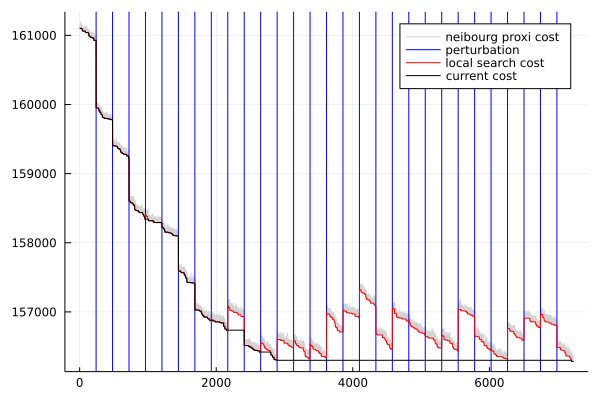

In [25]:
N = 10
T = 20
I = 100
σ = 1.1
seed = 1

S = generate_random_data(N,T,I,σ,seed)

S = .9*S + .1*(rand(N,T,I) .- .5)

S = round.(Int, min.(99, max.(0, 100 * (S .+ 1) ./ 2)))

S = S./1

maxitermain = 30
maxiter = 25
tolerance = 1
nbhdsize = 10
β = 1.
seed = 1234567

Y = generate_random_solution(N, I, seed)
centers = generate_centers_means(S, Y)
Y = rand_rows_2_nearest_center(S, Y, centers, 1., seed)

Yils, cost, costtemp, costnbhd, perturbindex = MH3_iterated_local_search(S, Y, maxitermain, maxiter, tolerance, nbhdsize, β, seed)

display(Yils)
display(cost[end])
pltcost = plot()
plot!(costnbhd, color=:lightgrey, label="neibourg proxi cost")
vline!(perturbindex, color=:blue, label="perturbation")
plot!(costtemp, color=:red, label="local search cost")
plot!(cost, color=:black, label="current cost")
display(pltcost)


In [ ]:
rng = MersenneTwister(seed)

# Population-Based Metaheuristics

### Genetic Algorithm

In [22]:
function population_initialization_00(
            S::Array{Float64,3},
            K::Int64,                 # Population size
            seed=rand(UInt32)::UInt32
        )
    
    N, T, I = size(S)
    Yseed = generate_random_solution(N, I, seed)
    Ypop = Array{Array{Int32, 2}, 1}(undef, K)

    rng = MersenneTwister(seed)
    for k = 1:K
        newseed = rand(rng, UInt32)
        Ypop[k] = generate_random_solution(N, I, newseed)
    end
    
    return Ypop
end


function population_initialization_01(
            S::Array{Float64,3},
            K::Int64,                 # Population size
            seed=rand(UInt32)::UInt32
        )
    
    N, T, I = size(S)
    Yseed = generate_random_solution(N, I, seed)
    Ypop = Array{Array{Int32, 2}, 1}(undef, K)

    rng = MersenneTwister(seed)
    centers = generate_centers_means(S, Yseed)
    for k = 1:K
        newseed = rand(rng, UInt32)
        Ypop[k] = rand_rows_2_nearest_center(S, Yseed, centers, 1., newseed)
    end
    
    return Ypop
end

population_initialization_01 (generic function with 2 methods)

In [23]:
function crossover( 
            Y1::Array{Int32,2},
            Y2::Array{Int32,2},
            γ=.5::Float64,                    # Proportion of the rows of Y1 to select
            seed=rand(UInt32)::UInt32
        )
    
    I, N = size(Y1)
    rng = MersenneTwister(seed)
    Iperm = randperm(rng, I)
    

    # Memory allocation
    Ynew = Array{Int32, 2}(undef, I, N)
    
    rows_from_Y1 = floor(Int64, γ*I)
    print(rows_from_Y1,'\n')
    
    for i=1:I
        if i <= rows_from_Y1
            Ynew[Iperm[i], :] = Y1[Iperm[i], :]
            print("1 ",Iperm[i],'\n')
        else
            Ynew[Iperm[i], :] = Y2[Iperm[i], :]
            print("2 ",Iperm[i],'\n')
        end
    end
    
    return Ynew
end

crossover (generic function with 3 methods)

In [112]:
function MH4_genetic_algorithm(S, Ypop, maxiter, δ, λ)
    N, T, I = size(S)
    K = length(Ypop)
    rng = MersenneTwister(seed)
    
    centers = Array{Array{Float64, 2}, 1}(undef, K)
    costs = zeros(K)
    fitness = zeros(K)
    roulette = zeros(K)
    
    Ypop_new = Array{Array{Int32, 2}, 1}(undef, K)
    centers_new = Array{Array{Float64, 2}, 1}(undef, K)
    costs_new = zeros(K)

    for k = 1:K
        centers[k] = generate_centers_means(S, Ypop[k])
        costs[k] = objective_function(S, Ypop[k], centers[k])
    end
    
    ### SELECTION STRATEGY
    fitness = (1 ./ costs)
    roulette_probs = fitness ./ sum(fitness)
    roulette = Multinomial(1,roulette_probs)
    
    ### REPRODUCTION STRATEGY
    rep_strateg = Bernoulli(δ) # 1 for crossover, 0 for mutation (try others when testing?)
    
    
    ### Selection and Reproduction
    iter = 1
    while (iter < maxiter)
        for k = 1:K
            if rand(rng,rep_strateg)
                one = argmax(rand(rng,roulette_probs))
                two = argmax(rand(rng,roulette_probs))
                if one == two
                    Ypop_new[k] = Ypop[k] # copy?
                else
                    newseed = rand(rng, UInt32)
                    Ypop_new[k] = crossover(Ypop[one], Ypop[two], .5, newseed)
                end
            else
                one = argmax(rand(rng,roulette_probs))
                newseed = rand(rng, UInt32) 
                Ypop_new[k] = random_neighbour(Ypop[one], newseed, :singleswap)
            end

            centers_new[k] = generate_centers_means(S, Ypop_new[k])
            costs_new[k] = objective_function(S, Ypop_new[k], centers_new[k])
        end

        ### REPLACEMENT STRATEGY: full replacement (didn't work)
        # Ypop = copy(Ypop_new)
        # centers = copy(centers_new)
        # costs = copy(costs_new)

        ### REPLACENENT STRATEGY: elitist replacement of worst λ old by λ best new
        sortperm_old = sortperm(costs)
        sortperm_new = sortperm(costs_new)    
        Ypop[sortperm_old[(K-λ+1):K]] = copy(Ypop_new[sortperm_new[1:λ]])        
        centers[sortperm_old[(K-λ+1):K]] = copy(centers_new[sortperm_new[1:λ]])
        costs[sortperm_old[(K-λ+1):K]] = copy(costs_new[sortperm_new[1:λ]])
        
        
        fitness = (1 ./ costs)
        roulette_probs = fitness ./ sum(fitness)
        roulette = Multinomial(1,roulette_probs)
        
        iter = iter + 1
    end
    return centers, costs, costs_new
end

MH4_genetic_algorithm (generic function with 2 methods)

In [196]:
N = 4
T = 20
I = 60
σ = .63
S = generate_random_data(N, T, I, σ, 100)

K = 20 # Population size
seed = 12345

Ypop = population_initialization_00(S, K, seed)
maxiter = 100
λ = floor(Int,2/3 * K)
δ = 0

centers, costs, costs_new = MH4_genetic_algorithm(S, Ypop, maxiter, δ, λ);

In [197]:
costs

20-element Array{Float64,1}:
 650.7408381257055
 650.8072613517263
 651.1327380274361
 649.8938928997451
 649.8670460009325
 651.0771929933147
 648.8966354588473
 649.516229292072 
 650.7721787604562
 651.2986572326978
 651.0135886200509
 650.4710889573859
 651.2691938215166
 649.7345280333478
 651.4342237439696
 649.7771770971896
 649.7493415072714
 650.7971301711623
 649.7299202880407
 651.3193704867771

In [111]:
v_new=[30,20,50,10,40]
p_new=sortperm(v_new)

v_old=[500,100,200,400,300]
p_old=sortperm(v_old)
λ=3
K=5

v_old[p_old[(K-λ+1):K]] = copy(v_new[p_new[1:λ]])
v_old

5-element Array{Int64,1}:
  30
 100
 200
  20
  10